In [3]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd 
import os 
%matplotlib widget
import ipywidgets as widgets

# Function section 
class data_processing: 
    def __init__(self):
        self.path = []

    def import_scattering_data(self, path, origin_data = 'Raw', **kwargs):
        """ 
        Prepare the data from the path folder to be used for transmission correction
        
        Parameters: Path - full path of the folder containing all your data
        
        Return: li - an array containing all the q-range, intensity and error data
                qdata - raw q-range data
                idata - raw intensity data 
                err - raw incertitude data  
        """
        
        data_path = (path +'*dat_counts')
        B = glob.glob(data_path)
        
        # Show list of file
        files = os.listdir(path)
        print ('CHECK THE SAMPLES POSITION AND INDEX FOR BACKGROUND SUBSTRACTION')

        for index, file in enumerate(files):
            print(index, file)
            
                
        # Create a list for the data
        qdata = []
        idata = []
        err_data = []
        
        for filenames in B:
            df = pd.read_csv(filenames,delim_whitespace=True, header=None)
            df = df[2:] 

            # Convert the DataFrame columns to numeric dtype
            df = df.apply(pd.to_numeric, errors='coerce')
            # Convert the list to a NumPy array
            arr = np.array(df)

            # Extract the first three columns
            data1 = arr[:, :3]
            qdata1 = arr[:,0]
            idata1 = arr[: , 1]
            err_data1 = arr[:,2]

            qdata.append(qdata1)
            idata.append(idata1)
            err_data.append(err_data1)

        # Convert the Series to array
        qdata = pd.Series(qdata)
        idata = pd.Series(idata)
        err_data = pd.Series(err_data)

        qdata = qdata.to_numpy()
        idata = idata.to_numpy()
        err_data = err_data.to_numpy()
        
        # Conversion in nm
        qdata *= 10
        
            
        # Define the names of the samples
        names = os.listdir(path)
        sample_name = []
        for i in range (len(names)):
            name1 = names[i].split('_unwarped')[0]
            sample_name.append(name1)    
                
        if 'plot' in kwargs: 
            for i in range(len(qdata)):
                x1 = qdata[i]
                y1 = idata[i]
                plt.loglog(x1,y1)  
            plt.ylabel('Intensity')
            plt.xlabel('q 1/nm')
            plt.show()
            
        return qdata,idata,err_data, B, sample_name, origin_data

    
    def transmission_correction (self, idata, err_data):
        transmission_data = []
        idata_corrected = []
        err_corrected = []

        for i in range(len(idata)):
            data1 = np.divide (idata[i][0],idata[0][0])
            transmission_data.append(data1)

        for i in range(len(idata)):
            data1 = np.divide (idata[i],transmission_data[i])
            idata_corrected.append(data1)
            data2 = np.divide(err_data[i],transmission_data[i])
            err_corrected.append(data2)

        return idata_corrected, transmission_data, err_corrected
        

    def background_substraction (self, idata_corrected,err_corrected,qdata, sample_name,**kwargs): 
        """ 
        Do the background substraction of the data based on the different input parameters. 
        
        Parameters: idata_corrected - Transmission corrected datas
                    err-corrected - insertitude of the intensity corrected
                    qdata = q- range of the data in nm 
                    air - position of the air scattering (also called empty beam) data in the data-array
                    capillary - position of the capillary scattering (or kapton or any other background that needs to be substracted) data in the data-array
                    water - position of the water scattering (or any other solvent background that needs to be substracted) data in the data-array
                    bck_coef - backround coefficient that will be multiplied to the background data (function of the concentration of your sample)
                    q_lim - experimental distance, will be used to cut the exploitable q-range. Options are '107', '67', '27','5'
                    
        Return: Qdata- usable q-range for the data set
                Idata - background substracted intensity data
                Err - background substracted incetitude on the intensity 
                sname - sample name
        """
        # Check how to do the background substraction 
        bck = []
        for key, value in kwargs.items():
            f = (f"{key} = {value}")
            bck.append(f)
            
        if 'air' in kwargs and not 'capillary' in kwargs:
            case = 1 
        if not all(key in kwargs for key in ["air", "bck_coef", "q_lim"]):
            raise ValueError("Invalid input arguments, arguments should be [air =0, bck_coef = 0.99, q_lim = 107]")
        
        elif 'air' in kwargs and 'capillary' in kwargs and not 'water' in kwargs:
            case = 2 
            if not all(key in kwargs for key in ["air", "capillary", "bck_coef", "q_lim"]):
                raise ValueError("Invalid input arguments, arguments should be [air =0, capillary = 1, bck_coef = 0.99, q_lim = 107]")
        
        elif 'air' in kwargs and 'capillary' in kwargs and 'water' in kwargs:
            case = 3
            if not all(key in kwargs for key in ["air", "capillary", "water", "bck_coef", "q_lim"]):
                raise ValueError("Invalid input arguments, arguments should be [air =0, capillary = 1, water = 2, bck_coef = 0.99, q_lim = 107]")
            
        # Define the coef to substract the background. Needs to be taken into account the sample concentration
        if 'bck_coef'  in kwargs:
            bck_coef = kwargs['bck_coef']    

        elif 'bck_coef' not in kwargs:
            bck_coef = 0.99  

        # Get all data at the same length
        lmin = min(len(arr) for arr in idata_corrected)
        idata_corrected = [arr[:lmin] for arr in idata_corrected]
        err_corrected = [arr[:lmin] for arr in err_corrected]
        bck_qdata = [arr[:lmin] for arr in qdata]
        
        bck_data = []
        bck_err = []

        if case == 1:
            # Do background substraction on the data depending on the appropriate backgtound choosen in kwargs
            air_data = idata_corrected[kwargs['air']]
            err_air = err_corrected[kwargs['air']]
            
            for i in range(len(idata_corrected)):
                data1 = idata_corrected[i] - air_data * bck_coef
                data2 = err_corrected[i] - err_air * bck_coef
                bck_data.append (data1)
                bck_err.append(data2)
                
            # Remove the background data to keep only the samples in the data set
            bck_data = np.delete(bck_data,[kwargs['air']], axis = 0)
            bck_err =  np.delete(bck_err,[kwargs['air']], axis = 0)
            bck_qdata = np.delete(bck_qdata,[kwargs['air']], axis = 0)
            sname = np.delete(sample_name,[kwargs['air']],axis = 0)

        elif case == 2: 
            # Do correction just with air and empty capillary
            air_data = idata_corrected[kwargs['air']]
            err_air = err_corrected[kwargs['air']]
            empty_cap = idata_corrected[kwargs['capillary']]
            err_cap = err_corrected[kwargs['capillary']]

            for i in range(len(idata_corrected)):
                data1 = idata_corrected[i] - empty_cap * bck_coef 
                data2 = err_corrected[i] - err_cap * bck_coef 
                bck_data.append (data1)
                bck_err.append(data2)

            
            # Remove the background data to keep only the samples in the data set
            bck_data = np.delete(bck_data,[kwargs['air'],kwargs['capillary']], axis = 0)
            bck_err =  np.delete(bck_err,[kwargs['air'],kwargs['capillary']], axis = 0)
            bck_qdata = np.delete(bck_qdata,[kwargs['air'],kwargs['capillary']], axis = 0)
            sname = np.delete(sample_name,[kwargs['air'],kwargs['capillary']],axis = 0)

        # Do correction with water, air and empty capillary
        elif case == 3:
            air_data = idata_corrected[kwargs['air']]
            err_air = err_corrected[kwargs['air']]
            empty_cap = idata_corrected[kwargs['capillary']]
            err_cap = err_corrected[kwargs['capillary']]
            water_bck = idata_corrected[kwargs['water']]
            err_water = err_corrected[kwargs['water']]
            I_water = water_bck - empty_cap
            err_w = err_water - empty_cap

            # Do the background substraction
            for i in range(len(idata_corrected)):
                data1 = idata_corrected[i] - empty_cap - I_water * bck_coef
                data2 = err_corrected[i] - err_cap - err_w * bck_coef
                bck_data.append (data1)
                bck_err.append(data2)
                
            # Remove the background data to keep only the samples in the data set
            bck_data = np.delete(bck_data,[kwargs['air'],kwargs['capillary'],kwargs['water']], axis = 0)
            bck_err =  np.delete(bck_err,[kwargs['air'],kwargs['capillary'],kwargs['water']], axis = 0)
            bck_qdata = np.delete(bck_qdata,[kwargs['air'],kwargs['capillary'],kwargs['water']], axis = 0 )
            sname = np.delete(sample_name,[kwargs['air'],kwargs['capillary'],kwargs['water']],axis = 0)
            
        print ('Case ' f"{case}")
        # Keep  samples part relevant for the data
        indices = []

        # Convert the list to a numpy array
        bck_qdata = np.array(bck_qdata)

        # Define the cut off region of the data depending on the experimental configuration
        if kwargs['q_lim'] == 147:
            cut_off = 0.05
        elif kwargs['q_lim'] == 107:
            cut_off = 0.07
        elif kwargs['q_lim'] == 67:
            cut_off = 0.12
        elif kwargs['q_lim'] == 27:
            cut_off = 0.25
        elif kwargs['q_lim'] == 5:
            cut_off = 4.5

        for col in range(bck_qdata.shape[0]):
            index = np.argmin(np.abs(bck_qdata[col, :] - cut_off))
            indices.append(index)

        Idata = [] 
        Qdata = []
        Err = []
        
        # Cut the data
        for i, data in enumerate(bck_data):
            cut_data1 = data[indices[i]:]
            Idata.append(cut_data1)
            cut_data2 = bck_qdata[i][indices[i]:]
            Qdata.append(cut_data2)
            cut_data3 = bck_err[i][indices[i]:]
            Err.append(cut_data3)  
         
        return Qdata, Idata, Err, sname         

    def process_data (self, path, origin_data, **kwargs):
        """
        Function including all the previous function of the class object - read the data in the path folder, clean the data, perform background substrction
        
        Paramters:  path - full path of the folder containing the data
                    air - position of the air scattering (also called empty beam) data in the data-array
                    capillary - position of the capillary scattering (or kapton or any other background that needs to be substracted) data in the data-array
                    water - position of the water scattering (or any other solvent background that needs to be substracted) data in the data-array
                    bck_coef - backround coefficient that will be multiplied to the background data (function of the concentration of your sample)
                    q_lim - experimental distance, will be used to cut the exploitable q-range. Options are '107', '67', '27','5'
                   
                   
        Return: Qdata - q-range of the transmission corrected and background substracted data in nm
                Idata - transmission corrected and background substracted data
                Err - incertitude on the transmission and background substracted data
                sname - sample name
                
        Example: 
        Qdata, Idata, Err, sname = dp.process_data(path,air = 0, capillary = 1, water = 2, bck_coef = 0.99, q_lim = 107)
        """
        
        qdata, idata, err_data, B,sample_name, origin_data = self.import_scattering_data(path, origin_data)
        idata_corrected, transmission_data, err_corrected = self.transmission_correction(idata, err_data)
        Qdata, Idata, Err, sname = self.background_substraction(idata_corrected, err_corrected, qdata, sample_name,**kwargs)
        return Qdata, Idata, Err, sname 
 
# Define the class object   
dp = data_processing()

def plot_scattering_curves (qdata,idata,**kwargs):
    """Create a graph for the scattering curves
        Parameters: q-data - q-range of the data in nm
                    idata - Intensity 
                    sname - sample name
                    legend - show legend
                    
        Return = none
    """
    plt.figure(figsize=(10, 6))
    
    for i in range(len(qdata)):
        x1 = qdata[i]
        y1 = idata[i]
    # Plotting the curves in loglog
        if 'sname' in kwargs: 
            sname = kwargs['sname']
            plt.loglog(x1,y1,label = sname[i]) 
        elif 'sname' not in kwargs:
            plt.loglog(x1,y1)
            
        if 'linear' in kwargs: 
            plt.plot(x1,y1)
        else:
            pass

    # Define the label of the curves 
    if 'ylabel' in kwargs: 
        plt.ylabel(kwargs['ylabel'])
    else:
        plt.ylabel('Intensity')
        
    plt.xlabel('q nm-1')
    if 'legend' in kwargs: 
        plt.legend()

    plt.show()   

def save_1D_data (path, sname, Qdata, Idata, Err):
    """Function that saves the data in a folder "1D" at your path.

    Parameters: 'path' where your data are stored,
                'sname, Qdata, Idata, Err' data processed in the process data function"""

    # Create the "1D" folder if it doesn't exist
    path_out_folder = os.path.join(path, '1D')
    os.makedirs(path_out_folder, exist_ok=True)

    for i in range(len(sname)):
        # Corrected the use of sname[i] instead of sample_name[i]
        substring = sname[i]
        path_out = os.path.join(path_out_folder, f'{substring}_1D.txt')

        arr = np.column_stack((Qdata[i], Idata[i], Err[i]))

        np.savetxt(path_out, arr, delimiter=',')

    print(f'1D data have been saved at: {path_out_folder}')
    return

def extract_between(input_str,start,end):
    """ Extract substring from in-between the two input parameters "Start" and "End"

    Args:
        input_str (str): List of the strings 
        start (str): first character to extract
        end (str): last character to extract 

    Returns:
        str: list of extracted strings.
    """
    out_name = []
    for ii in range(len(input_str)):
        start_string = input_str[ii].rfind(str(start))
        last_string = input_str[ii].rfind(str(end))    
        section = input_str[ii][start_string+1:last_string]
        out_name.append(section)
    return out_name


 Load your data from the path defined below. Data should be radially integrated using the Bruker software and be in the format '.dat_counts'


Run the following function to analyse the data. Change input "Air = XX, capillary = XX and water = XX" with the index position of the corresponding files in your folder (index = position - 1) 

In [6]:
path = 'C:/Users/sapd/Desktop/new/DATA ANALYSIS RAM/P23_0028-MetrINo-Data Analysis new/Metr7_SAXS_UCNPs_D4_EtOH_131223/Metr7-Corrections/Metr7.2/'
Qdata, Idata, Err, sname = dp.process_data(path, origin_data= 'Raw', air = 0, capillary = 1, water = 2, bck_coef = 0.5, q_lim = 147)

CHECK THE SAMPLES POSITION AND INDEX FOR BACKGROUND SUBSTRACTION
0 00_emptybeam_147cm_10800s_unwarped_exported.dat_counts
1 01_empty_147cm_10800s_unwarped_exported.dat_counts
2 02_D4_EtOH_Bf_147cm_10800s_unwarped_exported.dat_counts
3 A1H1_D4_147cm_10800s_1D.txt
4 A1H1_D4_147cm_10800s_unwarped_exported.dat_counts
5 A2H1_D4_147cm_10800s_1D.txt
6 A2H1_D4_147cm_10800s_unwarped_exported.dat_counts
7 B1H1_D4_147cm_10800s_1D.txt
8 B1H1_D4_147cm_10800s_unwarped_exported.dat_counts
9 B2H1_D4_147cm_10800s_1D.txt
10 B2H1_D4_147cm_10800s_unwarped_exported.dat_counts
Case 3


Plot the transmission and background corrected data

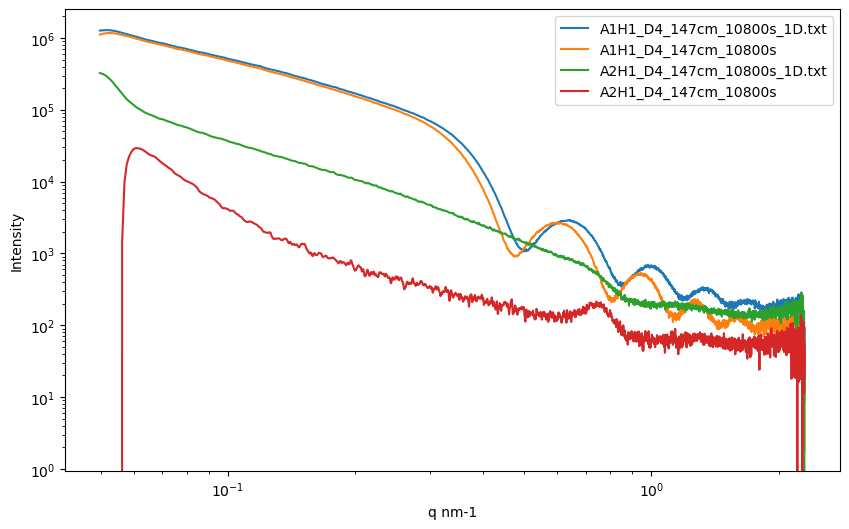

In [7]:
# Extract the name of the samples: 
out_name = extract_between(sname,'\\','_unwarped')

# Plot the data 
plot_scattering_curves(Qdata,Idata,sname = sname, legend = 1)

Save the data in the path you have defined

In [137]:
# Save the data
save_1D_data (path, sname, Qdata, Idata, Err)

1D data have been saved at: C:/Users/sapd/Desktop/new/DATA ANALYSIS RAM/P23_0028-MetrINo-Data Analysis new/Metr7_SAXS_UCNPs_D4_EtOH_131223/Metr7-Corrections/Metr7.2/1D


## Debug section of the script 

#### Plot the RAW data

CHECK THE SAMPLES POSITION AND INDEX FOR BACKGROUND SUBSTRACTION
0 00_emptybeam_147cm_10800s_unwarped_exported.dat_counts
1 01_empty_147cm_10800s_unwarped_exported.dat_counts
2 02_D4_EtOH_Bf_147cm_10800s_unwarped_exported.dat_counts
3 A1H1_D4_147cm_10800s_unwarped_exported.dat_counts
4 A2H1_D4_147cm_10800s_unwarped_exported.dat_counts
5 B1H1_D4_147cm_10800s_unwarped_exported.dat_counts
6 B2H1_D4_147cm_10800s_unwarped_exported.dat_counts


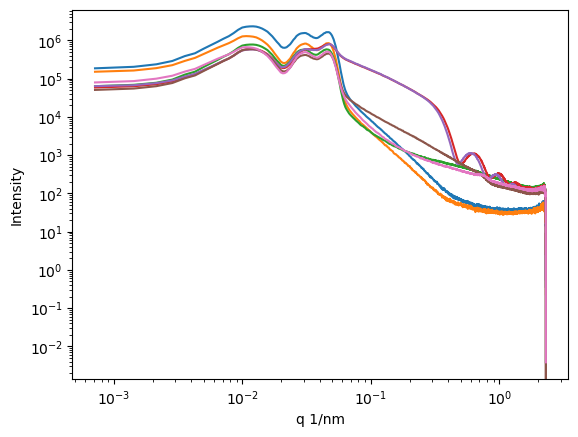

In [142]:
path = 'C:/Users/sapd/Desktop/new/DATA ANALYSIS RAM/P23_0028-MetrINo-Data Analysis new/Metr7_SAXS_UCNPs_D4_EtOH_131223/Metr7-Corrections/Metr7.2/'
qdata,idata,err_data, B, sample_name, origin_data = dp.import_scattering_data(path,plot = True)

#### Plot the Transmission corrected data

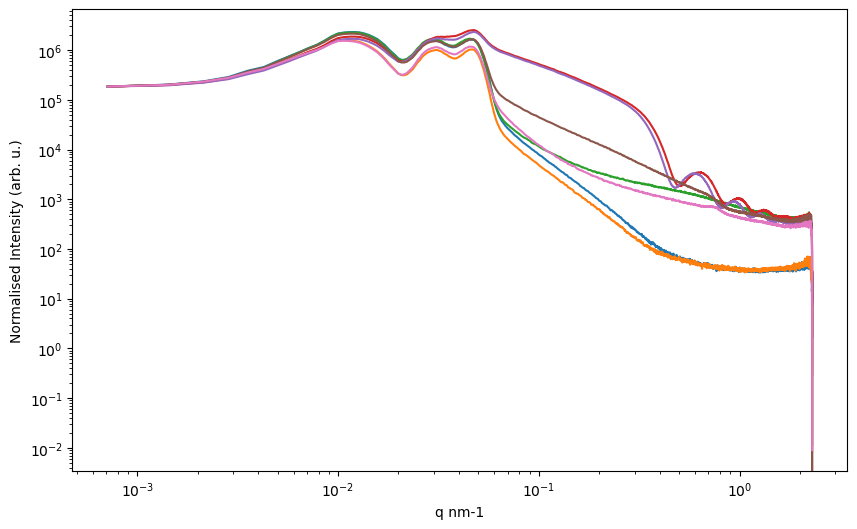

In [55]:
idata_corrected, transmission_data, err_corrected = dp.transmission_correction(idata, err_data)
plot_scattering_curves(qdata, idata_corrected, ylabel = 'Normalised Intensity (arb. u.)')

Case 2


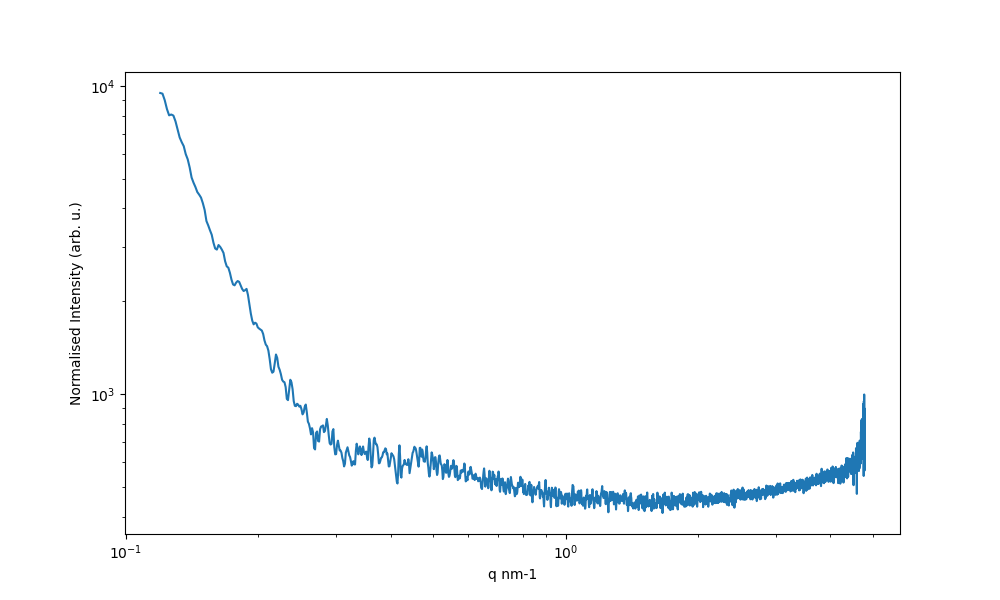

In [8]:
Qdata, Idata, Err, sname =  dp.background_substraction (idata_corrected,err_corrected,qdata,sample_name, air = 0, capillary = 1 , bck_coef = 1, q_lim = 67)
plot_scattering_curves(Qdata, Idata,  sname = sname, ylabel = 'Normalised Intensity (arb. u.)')